<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 11th exercise: <font color="#C70039">Vector Autoregressive Models - VAR: Dpi/Cons Forecast</font>
* Course: <a href="https://www.gernotheisenberg.de/time_series_forecasting.html">Time Series Forecasting (TSF)</a>
* Lecturer: <a href="https://www.gernotheisenberg.de/uebermich.html">Gernot Heisenberg</a>
* Date:   19.03.2025

<img src="./images/var.jpeg" style="float: center;" width="450">

---------------------------------
**GENERAL NOTE 1**:
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole.

**GENERAL NOTE 2**:
* Please, when commenting source code, just use English language only.
* When describing an observation please use English language, too
* This applies to all exercises throughout this course.  

---------------------

### <font color="ce33ff">DESCRIPTION OF THE NOTEBOOK CONTENT</font>:
This notebook show you how to develop four different baseline models to compare your real forecasts to.

-------------------------------------------------------------------------------------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points.
If a task is more challenging and consists of several steps, this is indicated as well.
Make sure you have worked down the task list and commented your doings.
This should be done by using markdown.<br>
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date.
    * set the date too and remove mine.
3. read the entire notebook carefully
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time.
    * understand the output
4. Use a VARMA model to predict realdpi and realcons
    * Since now, we used a VAR(p) model. However, we used the VARMAX function from statsmodels to do so, meaning that we can easily extend the VAR(p) model to a VARMA(p,q) model. 
    * In this exercise, use a VARMA(p,q) model to forecast realdpi and realcons.
    * Use the same train and test sets as in this chapter.
    * Generate a list of unique (p,q) combinations.
    * Rename the optimize_VAR function to optimize_VARMA, and adapt it to loop over all unique (p,q) combinations. 
    * Select the model with the lowest AIC, and perform the Granger causality test.
    * Pass in the largest order among (p,q). Is the VARMA(p,q) model valid?
    * Perform residual analysis.
    * Make forecasts on a four-step window over the test set. Use the last known value method as a baseline.
    * Calculate the MAPE. 
    * Is it lower or higher than that of our VAR(3) model?
-----------------------------------------------------------------------------------

## 11.0 Module import

In [30]:
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.varmax import VARMAX
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 11.1 Data loading & visualization

In [31]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


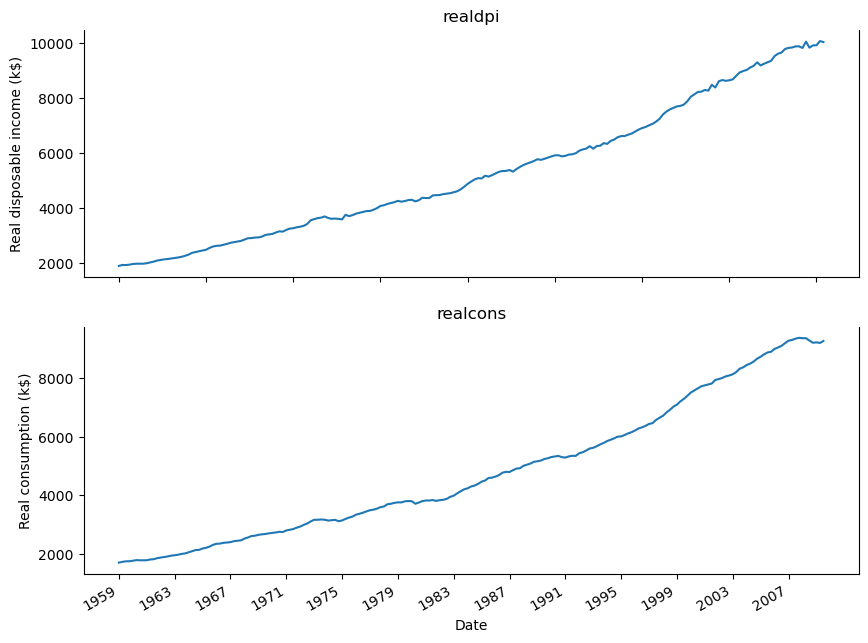

In [32]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

ax1.plot(macro_econ_data['realdpi'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income (k$)')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)

ax2.plot(macro_econ_data['realcons'])
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.show()

## 11.2 Augmented Dickey-Fuller test

In [34]:
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'])

print('realdpi')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_econ_data['realcons'])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realdpi
ADF Statistic: 2.9860253519546878
p-value: 1.0

---------------------

realcons
ADF Statistic: 1.5499123380509647
p-value: 0.9976992503412904


In [11]:
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'].diff()[1:])

print('realdpi differenced')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_econ_data['realcons'].diff()[1:])

print('realcons differenced')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realdpi differenced
ADF Statistic: -8.864893340673008
p-value: 1.4493606159108096e-14

---------------------

realcons differenced
ADF Statistic: -4.204306080845247
p-value: 0.0006479282158627571


After 1st order differencing both time series are stationary now.

## 11.3 Optimizing the VAR (VARMAX) model

We will use a VAR(p) model. However, we used the VARMAX function from statsmodels to do so. 
This means that we could extend the VAR(p) model to a VARMA(p,q) model easily.

In [36]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.varmax import VARMAX

def optimize_VAR(endog: Union[pd.Series, list]) -> pd.DataFrame:

    results = []
    # Vary the order p from 0 to 14
    for i in tqdm_notebook(range(15)): 
        try:
            model = VARMAX(endog, order=(i, 0)).fit(dips=False) # MA is zero -> VAR and not VARMA
        except:
            continue

        aic = model.aic
        results.append([i, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'AIC']

    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

#### NOTE
We must define the train and test sets. In this case, we’ll use 80% of the data for training and 20% for testing. 
This means that the last 40 data points will be used for testing and the rest is used for training. 

Since the VAR(p) model requires both series to be stationary, we’ll split on the differenced dataset and feed 
the differenced training set to the optimize_VAR function().

In [37]:
endog = macro_econ_data[['realdpi', 'realcons']]

endog_diff = macro_econ_data[['realdpi', 'realcons']].diff()[1:]

train = endog_diff[:162]
test = endog_diff[162:]

result_df = optimize_VAR(train)
result_df

  0%|          | 0/15 [00:00<?, ?it/s]

,p,AIC
0,3,3123.070082
1,5,3123.708523
2,6,3126.855595
3,4,3129.194044
4,2,3130.091668
5,7,3133.395666
6,1,3134.333343
7,8,3137.149013
8,9,3140.367183
9,10,3147.838875


### Test for Causality
Now, let's prepare for the Granger-Causality-Test.

The null hypothesis for this test states that y_2,t does not Granger-cause y_1,t. Again,
we will use the p-value with a critical value of 0.05 to determine whether we will reject
the null hypothesis or not. In the case where the returned p-value of the Granger causality
test is less than 0.05, we can reject the null hypothesis and say that y_2,t Grangercauses
y_1,t.

<font color = red>IMPORTANT NOTE:</font>

The reason the Granger causality test is performed after the VAR(p) model is selected, is simply
because the test requires us to specify the number of lags to be included in the test, 
which is equivalent to the order of the model. 

For example, since p=3 the Granger causality test will determine if the past three
values of a time series are statistically significant in forecasting the other time series.

Make sure that you check for causality bi-directionally.

In [38]:
print('realcons Granger-causes realdpi?\n')
print('------------------')
granger_1 = grangercausalitytests(macro_econ_data[['realdpi', 'realcons']].diff()[1:], [3])

print('\nrealdpi Granger-causes realcons?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_econ_data[['realcons', 'realdpi']].diff()[1:], [3])

realcons Granger-causes realdpi?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=28.7191 , p=0.0000  , df=3
likelihood ratio test: chi2=26.8268 , p=0.0000  , df=3
parameter F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3

realdpi Granger-causes realcons?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=8.7625  , p=0.0326  , df=3
likelihood ratio test: chi2=8.5751  , p=0.0355  , df=3
parameter F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3


#### INTERMEDIATE RESULT

Running the Granger causality test for both variables returns a p-value smaller than
0.05 in both cases. Therefore, we can reject the null hypothesis and conclude that
realdpi Granger-causes realcons and realcons Granger-causes realdpi. Our
VAR(3) model is thus valid and can be used.

## 11.4 Model building and training

In [39]:
best_model = VARMAX(train, order=(3,0))
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realdpi', 'realcons']   No. Observations:                  162
Model:                              VAR(3)   Log Likelihood               -1544.535
                               + intercept   AIC                           3123.070
Date:                     Wed, 07 May 2025   BIC                           3175.559
Time:                             18:32:46   HQIC                          3144.381
Sample:                                  0                                         
                                     - 162                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.01, 0.03   Jarque-Bera (JB):          43.86, 4.35
Prob(Q):                        0.91, 0.87   Prob(JB):                   0.00, 0.11
Heteroskedasticity (H):         4.44, 3.59   Skew:                      0.14

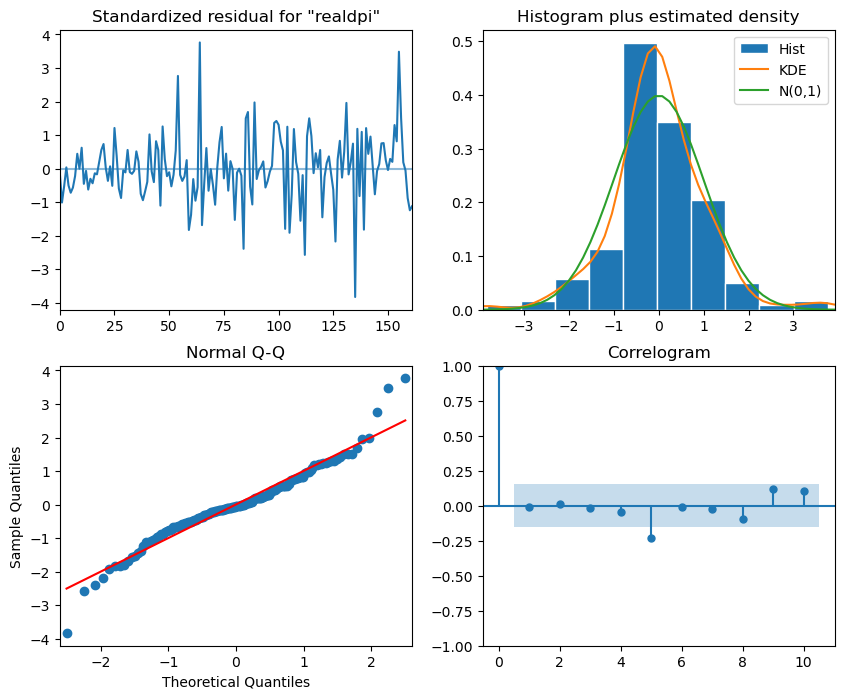

In [40]:
# realdpi
best_model_fit.plot_diagnostics(figsize=(10,8), variable=0)
plt.show()

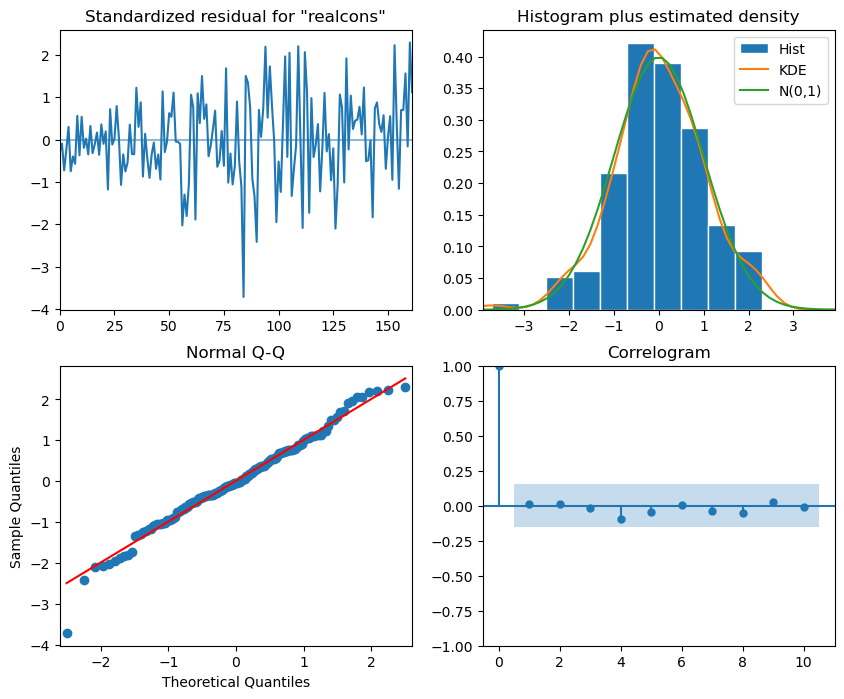

In [41]:
# realcons
best_model_fit.plot_diagnostics(figsize=(10,8), variable=1)
plt.show()

In [42]:
realgdp_residuals = best_model_fit.resid['realdpi']

lbvalue = acorr_ljungbox(realgdp_residuals, np.arange(1, 11, 1))

print(lbvalue)

      lb_stat  lb_pvalue
1    0.011641   0.914078
2    0.029400   0.985408
3    0.075829   0.994571
4    0.377929   0.984244
5    9.142497   0.103514
6    9.165332   0.164491
7    9.270079   0.233843
8   10.811512   0.212610
9   13.318051   0.148735
10  15.287303   0.121933


In [43]:
realcons_residuals = best_model_fit.resid['realcons']

lb_value = acorr_ljungbox(realcons_residuals, np.arange(1, 11, 1))

print(lb_value)

     lb_stat  lb_pvalue
1   0.023877   0.877199
2   0.068715   0.966226
3   0.068792   0.995299
4   0.235719   0.993577
5   0.377772   0.995920
6   0.787312   0.992410
7   1.015247   0.994579
8   2.150382   0.976051
9   2.437078   0.982528
10  2.442743   0.991684


#### INTERMEDIATE RESULTS

Since the model passed both, the qualitative and quantitative aspects of residual analysis, we can move on to forecasting realcons and realdpi using a VAR(3) model.
We will compare the VAR(3) model to a baseline that simply predicts the last observed value. 

We’ll forecast four steps into the future, which is equivalent to forecasting one full year as the data is sampled quarterly. 
We’ll thus perform a rolling forecast four steps into the future over the entire length of the test set.

## 11.5 Forecasting realdpi/realcons

In [44]:
''' 
    define the forecasting function in the same manner as many notebooks ago (compare the function to earlier implementations).
    It will need to output predictions for both realdpi and realcons, so we must return two lists containing the forecasts.
'''
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon
    end_idx = train_len

    # VAR model
    if method == 'VAR':

        realdpi_pred_VAR = []
        realcons_pred_VAR = []

        for i in range(train_len, total_len, window):
            model = VARMAX(df[:i], order=(3,0)) #p=3, q=0
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)

            oos_pred_realdpi = predictions.predicted_mean.iloc[-window:]['realdpi']
            oos_pred_realcons = predictions.predicted_mean.iloc[-window:]['realcons']

            realdpi_pred_VAR.extend(oos_pred_realdpi)
            realcons_pred_VAR.extend(oos_pred_realcons)

        return realdpi_pred_VAR, realcons_pred_VAR

    # baseline model
    elif method == 'last':
        realdpi_pred_last = []
        realcons_pred_last = []

        for i in range(train_len, total_len, window):

            realdpi_last = df[:i].iloc[-1]['realdpi']
            realcons_last = df[:i].iloc[-1]['realcons']

            realdpi_pred_last.extend(realdpi_last for _ in range(window))
            realcons_pred_last.extend(realcons_last for _ in range(window))

        return realdpi_pred_last, realcons_pred_last

In [45]:
TRAIN_LEN = len(train)
HORIZON = len(test)
# The window is 4, since we want to forecast four time steps into the future at a time, 
# which is equivalent to 1 year
WINDOW = 4 

realdpi_pred_VAR, realcons_pred_VAR = rolling_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VAR')

Remember we are working with the differenced values, thus we need to integrate back to the original time series

In [46]:
test = endog[163:]

test['realdpi_pred_VAR'] = pd.Series()
test['realdpi_pred_VAR'] = endog.iloc[162]['realdpi'] + np.cumsum(realdpi_pred_VAR)

test['realcons_pred_VAR'] = pd.Series()
test['realcons_pred_VAR'] = endog.iloc[162]['realcons'] + np.cumsum(realcons_pred_VAR)

test

,realdpi,realcons,realdpi_pred_VAR,realcons_pred_VAR
163,7887.7,7389.2,7829.222186,7354.322994
164,8053.4,7501.3,7897.185023,7430.252053
165,8135.9,7571.8,7960.558315,7496.624960
166,8222.3,7645.9,8014.750371,7556.608949
167,8234.6,7713.5,8080.695197,7630.996921
168,8296.5,7744.3,8142.386141,7692.849893
169,8273.7,7773.5,8200.118577,7753.874919
170,8484.5,7807.7,8259.360715,7812.549797
171,8385.5,7930.0,8264.384699,7864.650413
172,8611.6,7957.3,8320.857056,7895.075171


In [47]:
# add the baseline model result
realdpi_pred_last, realcons_pred_last = rolling_forecast(endog, TRAIN_LEN, HORIZON, WINDOW, 'last')

test['realdpi_pred_last'] = realdpi_pred_last
test['realcons_pred_last'] = realcons_pred_last

test

,realdpi,realcons,realdpi_pred_VAR,realcons_pred_VAR,realdpi_pred_last,realcons_pred_last
163,7887.7,7389.2,7829.222186,7354.322994,7716.0,7199.9
164,8053.4,7501.3,7897.185023,7430.252053,7716.0,7199.9
165,8135.9,7571.8,7960.558315,7496.624960,7716.0,7199.9
166,8222.3,7645.9,8014.750371,7556.608949,7716.0,7199.9
167,8234.6,7713.5,8080.695197,7630.996921,8135.9,7571.8
168,8296.5,7744.3,8142.386141,7692.849893,8135.9,7571.8
169,8273.7,7773.5,8200.118577,7753.874919,8135.9,7571.8
170,8484.5,7807.7,8259.360715,7812.549797,8135.9,7571.8
171,8385.5,7930.0,8264.384699,7864.650413,8273.7,7773.5
172,8611.6,7957.3,8320.857056,7895.075171,8273.7,7773.5


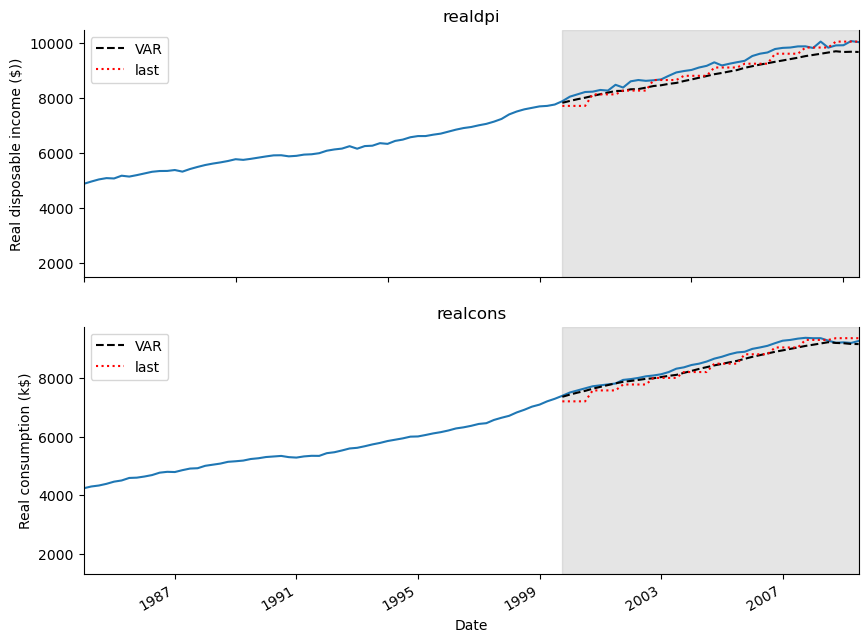

In [48]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

ax1.plot(macro_econ_data['realdpi'])
ax1.plot(test['realdpi_pred_VAR'], 'k--', label='VAR')
ax1.plot(test['realdpi_pred_last'], 'r:', label='last')
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income ($))')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)
ax1.axvspan(163, 202, color='#808080', alpha=0.2)
ax1.set_xlim(100, 202)
ax1.legend(loc=2)

ax2.plot(macro_econ_data['realcons'])
ax2.plot(test['realcons_pred_VAR'], 'k--', label='VAR')
ax2.plot(test['realcons_pred_last'], 'r:', label='last')
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)
ax2.axvspan(163, 202, color='#808080', alpha=0.2)
ax2.set_xlim(100, 202)
ax2.legend(loc=2)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))
plt.xlim(100, 202)

fig.autofmt_xdate()

#### RESULTS 1:
You can see that both lines are very close to the actual values of the test set, making it hard to visually determine which method is better.

In [49]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [50]:
mape_realdpi_VAR = mape(test['realdpi'], test['realdpi_pred_VAR'])
mape_realdpi_last = mape(test['realdpi'], test['realdpi_pred_last'])

mape_realcons_VAR = mape(test['realcons'], test['realcons_pred_VAR'])
mape_realcons_last = mape(test['realcons'], test['realcons_pred_last'])

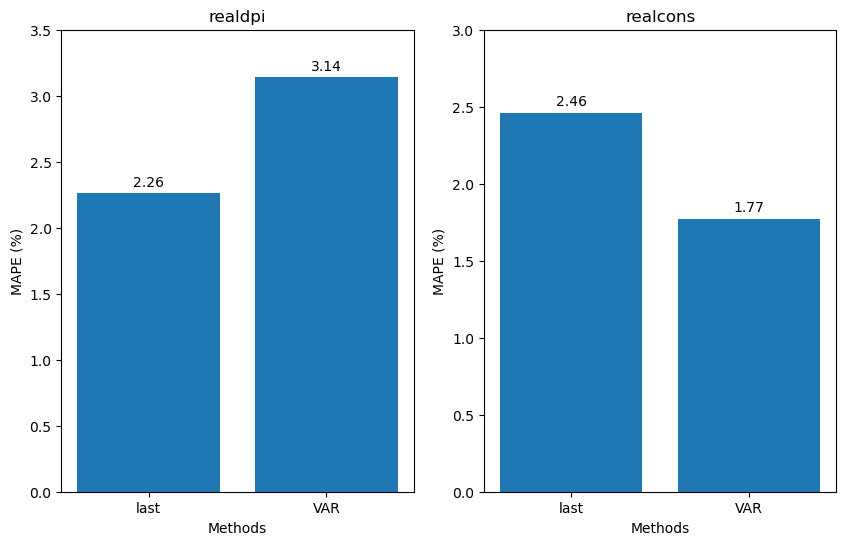

In [51]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

x = ['last', 'VAR']
y1 = [mape_realdpi_last, mape_realdpi_VAR]
y2 = [mape_realcons_last, mape_realcons_VAR]

ax1.bar(x, y1)
ax1.set_xlabel('Methods')
ax1.set_ylabel('MAPE (%)')
ax1.set_title('realdpi')
ax1.set_ylim(0, 3.5)

ax2.bar(x,y2)
ax2.set_xlabel('Methods')
ax2.set_ylabel('MAPE (%)')
ax2.set_title('realcons')
ax2.set_ylim(0, 3)

for index, value in enumerate(y1):
    ax1.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

for index, value in enumerate(y2):
    ax2.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')
plt.show()

#### RESULTS 2:

We can easily see that the VAR(3) model performs worse than the baseline forecasting the realdpi but better than the baseline for realcons. 
This is an ambiguous situation. There is no clear result, since the model does not outperform the baseline in both situations.

We can hypothesize that in the case of realdpi, realcons is not predictive enough to make more accurate forecasts than the baseline, even though the Granger causality test passed. Therefore, we should resort to using a variation of the SARIMAX model to predict realdpi. 

Thus, we could conclude that the VAR(3) model is not sufficient to accurately forecast realdpi and realcons. 
We could maybe suggest using two separate models, which could include realdpi and realcons as exogenous variables, while also potentially including moving average terms.